# 4.5 Hierarchical models

## Objectives

+ Bayes factors and their implementation for hypothesis testing in Python
+ Hierarchical models and their applications

 


## List of Symbols:
$--\mu$ is the mean<br>
$-- \sigma^2$ is the variance<br>
$--P$ is the probability<br>
$--θ$ is the vector of parameters <br>
$--BF$ is the Bayes Factor <br>
$--H_0$ is the null Hypothesis <br>
$--H_1$ is the alternate Hypothesis <br>


In [0]:
#@title Import { display-mode: "form" }

%matplotlib inline
import pymc3 as pm
import math
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
from pymc3.step_methods import smc
from tempfile import mkdtemp
from scipy.special import betaln
from scipy.stats import beta
import pandas as pd

import tensorflow as tf

from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()
  
import tensorflow_probability as tfp

tfd = tfp.distributions

## Definitions

+ **Bayes factors** - The Bayes factor is a ratio of the likelihood probability of two hypotheses, a null and an alternative hypothesis. It presents a new approach for hypothesis testing[1].

\begin{align}
\text{Bayes Factor} &= \frac{\text{Likelihood of data given Hypothesis } H_0}{\text{Likelihood of data given Hypothesis } H_1} \\
&= \frac{P(D \mid H_0)}{P(D \mid H_1)}
\end{align}

+ ** Hierarchical Models** - They are statistical models which are used to estimate various parameters of distributions using bayesian statistical methods where different but related parameters are used for each group. Various sub-models are combined to form the hierarchical model, and Bayes' theorem is used to integrate them with the observed data and account for all the uncertainty that is present[4].

In this notebook, we will go into detail for both of the above topics.

## Bayes Factors
Bayesian statisitcal methods are gaining more support now-a-days in the research community. Bayes factor provide an alternative to the p-value approach for hypothesis testing. P‐values present a problem that they can be used to make claims of ‘no effect’. P‐values signal the extremeness of the data under the assumption of the null hypothesis and so only tell us the probability of a test statistic at least as extreme as the one observed. P > 0.05 may reflect evidence for ‘no effect’ or data insensitivity, i.e. a failure to distinguish the null hypothesis from the alternative because, for example, the standard error (SE) is high.
It only tells us whether the hypothesis can be accepted or not.
Bayes factor is a measure of likelood ratio for two hypothesis. It gives the evidence of how better is one hypothesis from the other. The formula for Bayes Factors is mentioned in the previous cell. 
$$\text{Bayes Factor (BF) }= \frac{P(D \mid H_0)}{P(D \mid H_1)}$$

where $H_0$ and $H_1$ are two hyposthesis being compared, and BF gives us the evidence of $H_0$ being better than $H_1$.
It can be interpreted as below:
+ If, BF $< 3 $, No Evidence
+ If, 3 < BF < 10, Moderate Evidence
+ If, 10 < BF < 30, Strong evidence
+ If, BF > 30, very strong evidence

Below, we will do do an example implementation for hypothesis testing

We will use the coin-flipping problem[3] as example. We will have two models and compare them using the Bayes Factor.

+ B is the Beta function
+ n is the number of trials
+ h is the number of success(heads)

We will consider 100 flips of coin and compare two models, one with uniform prior and one with a more concentrated prior around $\theta$ = 0.5 

$M_1$ = With a prior of $\theta$ = 0.5<br>
$M_2$ = With no prior (uniform distribution which can be realized by beta distribution using $\alpha = \beta = 1$) <br>

The equations for the solution are as shown under:

the evidence can be found using the below equation:

![Image01](https://github.com/Health-Devices/Course-Uncertainty-Evaluation-in-Measurements-and-Machine-Learning/raw/d31e370d1410b8667fb33c98bf04c757ed406810/Course%20Material/4.5/scribing_11_4.PNG)

![Image01](https://github.com/Health-Devices/Course-Uncertainty-Evaluation-in-Measurements-and-Machine-Learning/raw/d31e370d1410b8667fb33c98bf04c757ed406810/Course%20Material/4.5/equations_11.3.PNG)

![Image01](https://github.com/Health-Devices/Course-Uncertainty-Evaluation-in-Measurements-and-Machine-Learning/raw/d31e370d1410b8667fb33c98bf04c757ed406810/Course%20Material/4.5/scribing_11_4.PNG)
Now we will use the above equations ( 11.14) to find out the Bayes factor for comparison of $M_1$ and $M_2$. For this initially we will consider n = 100 tosses of the coin and assume head comes 61 times out of those. keeping the prior for $M_1$ as o.5 , we get the Bayes factor as below

In [3]:
# Set up parameters
n=100
r=61
phi=0.5
alpha = beta =1

# Calculate Bayes Factor
BFu = (math.factorial(n)/(math.factorial(r) * math.factorial(n-r)))*pow(phi,r)*pow((1-phi),(n-r)) * (n+1)

print("The Bayes Factor is:", BFu)

The Bayes Factor is: 0.7181839592625815


We see from aboce that we get bayes factor of 0.71, which is less than 3. So according the criteria defined earlier, we will say that there is no evidence of $M_1$ being better than $M_2$

Now we will see what happens, if for the same models, we provide the input data as having 100 heads out of 200 tosses.

In [4]:
# Set up parameters
n=200
r=100
phi=0.5
alpha = beta =1

# Calculate Bayes Factor
BFu = (math.factorial(n)/(math.factorial(r) * math.factorial(n-r)))*pow(phi,r)*pow((1-phi),(n-r)) * (n+1)

print ("The Bayes Factor is:",BFu)

The Bayes Factor is: 11.326044280860541


Here we get BF = 11.32, which is more than 10. Hence from this result, we can say that $M_1$ is better than $M_2$ for the given data. We see this increase in BF due the fact, that the number of data increased and also heads and tails are equal in the distribution thus close to the prior of $M_1$

Now we below we have plotted the $log_{10}(BF)$ for various values of r and n. On the X-axis we have $f = \frac{r}{n}$ 

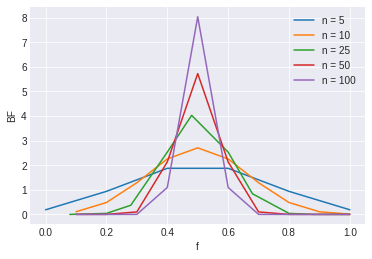

In [5]:
# Set up parameters
n = [5,10,25,50,100]
k = [.10,.2,.3,.4,.5,.6,.7,.8,.9,1]

# Plot Bayes Factor
for i in n:
    f_m=[]
    BF_m=[]
    for j in k:
        r=int(i*j)
        f=r/i
        BFu = (math.factorial(i)/(math.factorial(r) * math.factorial(i-r)))*pow(phi,r)*pow((1-phi),(i-r)) * (i+1)
        BF_m.append(BFu)
        f_m.append(f)
   
    plt.plot(f_m,BF_m,label=r'n = {:d}'.format(i))
    plt.legend()
    plt.xlabel("f")
    plt.ylabel("BF")
plt.show()

The curves are symmetric around $f = \frac{1}{2}$, because getting r heads has thesame probability as getting n − r heads when p = 1/2. We also see the BF increases as we increase the number of coin tosses. And within each n, it is highest around f = 0.5. That is the model $M_1$ with prior is better most when we take many data points and the heads are almost equal to tails in that


## Hierarchical Models

Hierarchical modeling is used when information is available on several different levels of observational units. Various models involve multiple parameters that can be regarded as related or connected in such a way that the problem implies dependence of the joint probability model for these parameters. Hierarchical Models come into play in these scenarios.


![Image01](https://github.com/Health-Devices/Course-Uncertainty-Evaluation-in-Measurements-and-Machine-Learning/raw/d31e370d1410b8667fb33c98bf04c757ed406810/Course%20Material/4.5/heirarchical_model.PNG)

In the picture above, we have different parameters $x_1$, $x_2$,.... $x_n$, which are are related to each other by $\theta$. From these different parameters, we get different but similar data points $D_i$


Below we will solve an example using hierarchical models.

The problem is to assess the performance of 18 different Sales Agents from two sales regions.
We will use the following binomial equation to simulate successful sales for agent k[6]:
$$
X_k \sim BINOM(n_k,\pi_k) \tag{1}\\
$$

where,
+ k = 1,2,3,.... 18 (sales agents) \\
+ $\pi_k$ is the success probability for agent k \\
+ $x_k$ is the successful number sales for agent k\\
+ $n_k$ is the number of sales tried for agent k \\


We can use heirarchical models to solve this problem and find the individual 90% credible intervals for each agent. We will pool the data within each region and compute an estimate of the probability of a successful sale within each region.
We will use the beta distribution to model the probabiility of success, as it outputs numbers between 0 and 1 with
a wide range of shapes depending on the parameters a and b.

$$\pi_k \sim BETA(a,b) \text{  for k =1,2,3,4...18} \tag{2}$$

(1) and (2) combined form a beta-binomial hierarchical model. The unknown model parameters a and b can be estimated from the available data.
To implement Bayesian estimation for this model, prior is defined using the beta distribution parameters a and b given by equations as $a \sim GAMMA(0.001,0.001)$ and $b \sim GAMMA(0.001,0.001)$ (as from book [6]).

Below figure is taken from the book [6] which has the problem data. We will take this data as the actual data

![Image01](https://github.com/Health-Devices/Course-Uncertainty-Evaluation-in-Measurements-and-Machine-Learning/raw/d31e370d1410b8667fb33c98bf04c757ed406810/Course%20Material/4.5/scribing_sample_data_17.3.png)

In [6]:
## creating actual data for agents from the problem
regions = ["Region 1","Region 1","Region 1","Region 1","Region 1","Region 1","Region 1","Region 1","Region 1",
           "Region 2","Region 2","Region 2","Region 2","Region 2","Region 2","Region 2","Region 2","Region 2"]
agents = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R"]
n_k = [12,30,20,26,24,17,38,20,17,24,27,19,14,10,17,33,28,14]
p_k = [.5,.7,.9,.58,.71,.65,.66,.8,.71,.67,.67,.58,.64,.80,.76,.64,.71,.5]

print("The number of sales regions:", len(regions))
print("The number of sales agents:", len(agents))
print("The size of n_k:", len(n_k))
print("The size of p_k:", len(p_k))

data = pd.DataFrame({'p_k':p_k, 'n_k':n_k,'agents':agents,'regions':regions},)
print(data)

The number of sales regions: 18
The number of sales agents: 18
The size of n_k: 18
The size of p_k: 18
     p_k  n_k agents   regions
0   0.50   12      A  Region 1
1   0.70   30      B  Region 1
2   0.90   20      C  Region 1
3   0.58   26      D  Region 1
4   0.71   24      E  Region 1
5   0.65   17      F  Region 1
6   0.66   38      G  Region 1
7   0.80   20      H  Region 1
8   0.71   17      I  Region 1
9   0.67   24      J  Region 2
10  0.67   27      K  Region 2
11  0.58   19      L  Region 2
12  0.64   14      M  Region 2
13  0.80   10      N  Region 2
14  0.76   17      O  Region 2
15  0.64   33      P  Region 2
16  0.71   28      Q  Region 2
17  0.50   14      R  Region 2


In [7]:
data.region = data.regions.map(str.strip)
region_unique = data.region.unique()

print("The number of region is:", len(region_unique))

region_lookup = dict(zip(region_unique, range(len(region_unique))))

The number of region is: 2


This problem can conventionaly be done in two ways:
+ Treat all the agents in same way and fit a single model to all the agents
+ Model each agent separately, thus we will have 18 models in total

These are both extremites. What we can do is build a heirarchical model on tha basis of 2 regions. So we will end up having 2 models which will fit each region. 

### PyMC3 Implementation

In [0]:
with pm.Model() as heirarchical_model:
    ## a and b
    a = pm.Gamma("a",0.001,0.001)
    b = pm.Gamma("b",0.001,0.001)
    ## pi from a and b
    pi = pm.Beta("pi",a,b)
    n = pm.Normal("n",24,10)
    ## noise
    #eps = pm.HalfNormal('eps', sd=1)
    
    x = pm.Binomial("x",n, pi)

In [0]:
with heirarchical_model:
    hierarchical_trace = pm.sample(draws=10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [n, pi_logodds__, b_log__, a_log__]
>Metropolis: [x]
Tuning was enabled throughout the whole trace.
Tuning was enabled throughout the whole trace.
The estimated number of effective samples is smaller than 200 for some parameters.


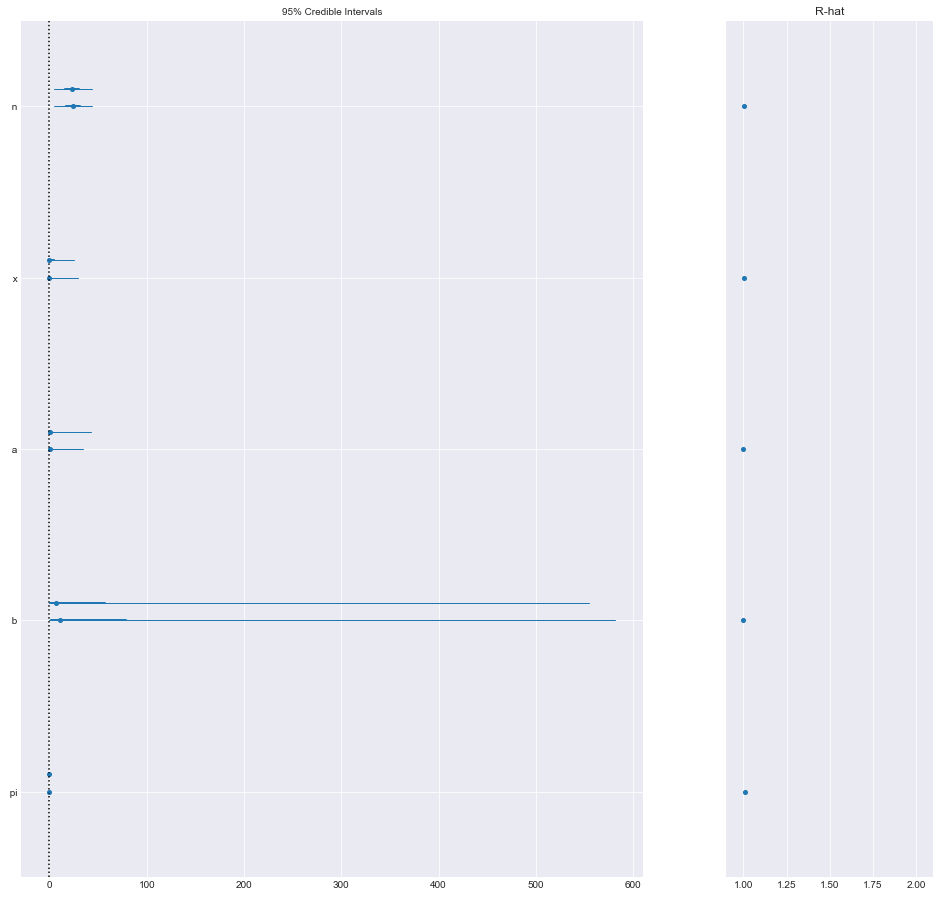

In [0]:
from pymc3 import forestplot, traceplot, plot_posterior

plt.figure(figsize=(14,14))
forestplot(hierarchical_trace)

In [0]:
var = ['n', 'x', 'pi','a','b']
pm.df_summary(hierarchical_trace, var)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
n,24.147355,10.074902,0.348284,4.993046e+00,43.706229,587.0,1.001266
x,4.197100,8.882097,0.798349,0.000000e+00,25.000000,51.0,1.002344
pi,0.171935,0.312334,0.026122,9.370181e-14,0.961816,51.0,1.008672
a,13.340624,78.392103,4.660789,2.041582e-05,38.585128,246.0,1.000157
b,109.443203,302.443890,5.511326,2.888897e-05,562.326893,2877.0,1.000609


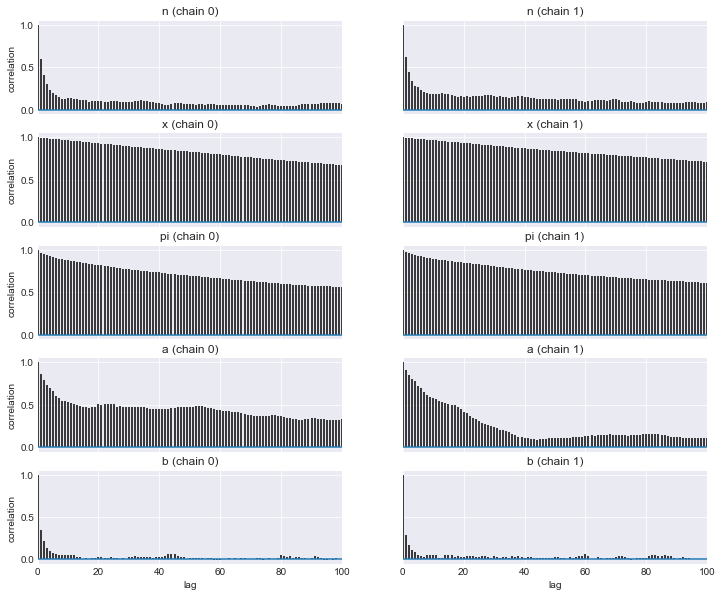

In [0]:
pm.autocorrplot(hierarchical_trace, var);

### TFP Implementation

In [0]:
###=================== Define the model =====================
def joint_log_prob(a, b, pi, n, x):
  
  # a and b
  rv_a = tfd.Gamma(concentration=0.001, rate=0.001)
  rv_b = tfd.Gamma(concentration=0.001, rate=0.001)
  
  # pi from a and b
  rv_pi = tfd.Beta(a, b)
  rv_n = tfd.Normal(loc=24., scale=10.)
  
  # x
  rv_x = tfd.Binomial(total_count=n, probs=pi)
   
  return (rv_a.log_prob(a) + rv_b.log_prob(b)
         + rv_pi.log_prob(pi) + rv_n.log_prob(n)
         + rv_x.log_prob(x))

def unnormalized_posterior(a, b, pi, n, x):
  return joint_log_prob(a, b, pi, n, x)

In [11]:
###=================== Sample the model =====================

# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Wrap sample_chain in function
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
  
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  
  return samples, is_accepted

# Call run_chain
initial_state = [tf.zeros(1), tf.zeros(1), tf.zeros(1), tf.zeros(1), tf.zeros(1)]
samples, is_accepted = run_chain()
sampled_a, sampled_b, sampled_pi, sampled_n, sampled_x = samples

W0824 19:18:41.568292 140475748681600 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:2403: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
###=================== Trace the sampling =====================

# Plot sampled_a
plt.plot(sampled_a, label="sampled_a")
plt.title("sampled_a")
plt.show()

# Plot sampled_b
plt.plot(sampled_b, label="sampled_b")
plt.title("sampled_b")
plt.show()

# Plot sampled_pi
plt.plot(sampled_pi, label="sampled_pi")
plt.title("sampled_pi")
plt.show()

# Plot sampled_n
plt.plot(sampled_n, label="sampled_n")
plt.title("sampled_n")
plt.show()

# Plot sampled_x
plt.plot(sampled_n, label="sampled_x")
plt.title("sampled_x")
plt.show()


## References

[1] Bayes factor from Wikipedia: https://en.wikipedia.org/wiki/Bayes_factor <br>
[2] Using Bayes factors for testing hypotheses about intervention effectiveness in addictions research. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5111611/<br>
[3] Bayes Factors and Marginal Likelihood. https://docs.pymc.io/notebooks/Bayes_factor.html<br>
[4] Bayesian hierarchical modeling. https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling<br>
[5] The Best Of Both Worlds: Hierarchical Linear Regression in PyMC3. http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/<br>
[6] W. Meeker, G. Hahn and L. Escobar, STATISTICAL INTERVALS A Guide for Practitioners and Researchers, 2nd ed. John Wiley & Sons Inc., 2017, pp. 353-360.<br>
[7] C. A.L and B. Jones, Practical Bayesian inference - A primer for Physical students. Cambridge: Cambridge University Press, 2017, p. Chapter 11.<br>
[8] ]Tensorflow Probability[Online] https://www.tensorflow.org/probability